In [ ]:
import pandas as pd
import numpy as np
import tensorflow as t
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

In [ ]:
import pandas as pd

file_path = 'Train_data.csv'
dataset = pd.read_csv(file_path) # Try 'latin-1' encoding. If this doesn't work, try 'cp1252'

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  int64  
 2   service                      25192 non-null  int64  
 3   flag                         25192 non-null  int64  
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [ ]:
# Handle non-numeric data by encoding categorical features
label_encoders = {}
for column in dataset.columns:
    if dataset[column].dtype == 'object':
        le = LabelEncoder()
        dataset[column] = le.fit_transform(dataset[column].astype(str))
        label_encoders[column] = le

In [ ]:
# Split data into features (X) and target (y)
X = dataset.drop(columns=['class'])  # Assuming 'target' is the label column
y = dataset['class']

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#Total Features
print("Total Features : ",len(dataset.columns)-1)

Total Features :  41


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


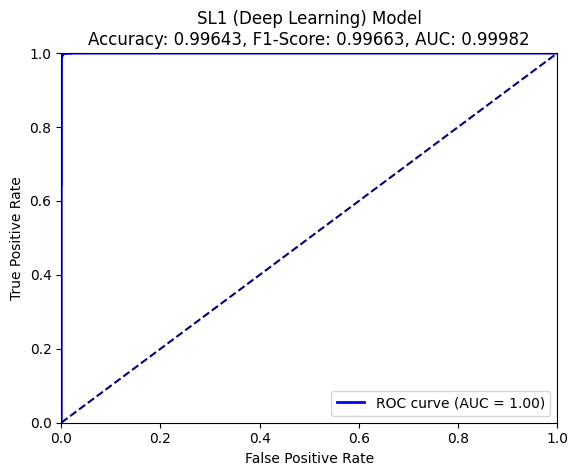

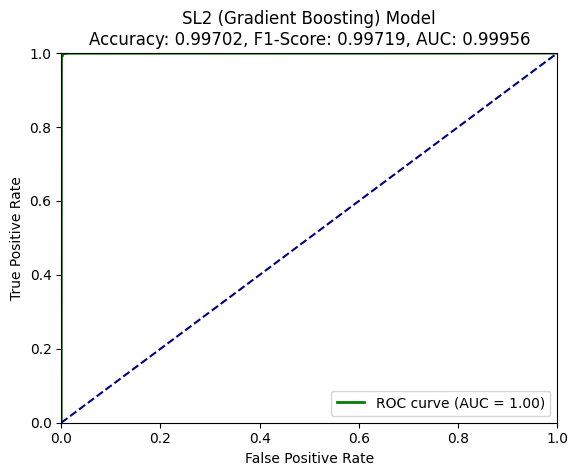


Final Results (Table 4):
                      Model       AUC  Accuracy  F1-Score
0       Logistic Regression  0.991393  0.955944  0.958644
1             Random Forest  0.999963  0.997817  0.997944
2         Gradient Boosting  0.999833  0.996825  0.997010
3             Deep Learning  0.999589  0.992459  0.992871
4   SL1: DL as meta-learner  0.999818  0.996428  0.996630
5  SL2: GBM as meta-learner  0.999562  0.997023  0.997194


In [ ]:
# Replace '?' with NaN and handle missing values
dataset.replace('?', np.nan, inplace=True)
dataset.dropna(inplace=True)  # Drop rows with NaN values

# If there are any categorical features, encode them
X = pd.get_dummies(dataset.iloc[:, :-1], drop_first=True).values

# Encode the target variable if it's categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataset.iloc[:, -1].values)  # Convert labels to 0, 1, etc.

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Define Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Define Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Define Deep Learning model
def create_dl_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the deep learning model
dl_model = create_dl_model()
dl_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# Predict with the deep learning model
y_pred_dl = dl_model.predict(X_test)

# Create SL1 Stacking model with DL as the meta-learner
sl1_estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Note: For stacking, we use only sklearn models. We can't include the DL model directly in stacking.
# Instead, we'll make predictions from the DL model and add them as a feature for meta-learner training.
dl_train_pred = dl_model.predict(X_train)
dl_test_pred = dl_model.predict(X_test)

# Add DL predictions as a new feature
X_train_sl1 = np.column_stack((X_train, dl_train_pred))
X_test_sl1 = np.column_stack((X_test, dl_test_pred))

sl1_model = StackingClassifier(estimators=sl1_estimators, final_estimator=LogisticRegression())
sl1_model.fit(X_train_sl1, y_train)

# Create SL2 Stacking model with GBM as the meta-learner
sl2_estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
]

X_train_sl2 = np.column_stack((X_train, dl_train_pred))
X_test_sl2 = np.column_stack((X_test, dl_test_pred))

sl2_model = StackingClassifier(estimators=sl2_estimators, final_estimator=GradientBoostingClassifier(n_estimators=100, random_state=42))
sl2_model.fit(X_train_sl2, y_train)

# Define the models dictionary
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Deep Learning': dl_model,  # We'll handle this separately for DL
    'SL1: DL as meta-learner': sl1_model,
    'SL2: GBM as meta-learner': sl2_model
}

# Evaluate the models and store results
results = []

for name, model in models.items():
    if name == 'Deep Learning':
        y_pred = y_pred_dl
    else:
        y_pred = model.predict_proba(X_test_sl1 if 'SL1' in name else (X_test_sl2 if 'SL2' in name else X_test))[:, 1]

    accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
    f1 = f1_score(y_test, (y_pred > 0.5).astype(int))
    roc_auc = roc_auc_score(y_test, y_pred)

    results.append({
        'Model': name,
        'AUC': roc_auc,
        'Accuracy': accuracy,
        'F1-Score': f1
    })

    # ROC curve data
    if name == 'SL1: DL as meta-learner':
        fpr_sl1, tpr_sl1, _ = roc_curve(y_test, y_pred)
        roc_auc_sl1 = roc_auc
        accuracy_sl1 = accuracy
        f1_sl1 = f1
    elif name == 'SL2: GBM as meta-learner':
        fpr_sl2, tpr_sl2, _ = roc_curve(y_test, y_pred)
        roc_auc_sl2 = roc_auc
        accuracy_sl2 = accuracy
        f1_sl2 = f1

# Plot ROC curve for SL1
plt.figure()
plt.plot(fpr_sl1, tpr_sl1, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_sl1)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SL1 (Deep Learning) Model\nAccuracy: {:.5f}, F1-Score: {:.5f}, AUC: {:.5f}'.format(accuracy_sl1, f1_sl1, roc_auc_sl1))
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for SL2
plt.figure()
plt.plot(fpr_sl2, tpr_sl2, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_sl2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SL2 (Gradient Boosting) Model\nAccuracy: {:.5f}, F1-Score: {:.5f}, AUC: {:.5f}'.format(accuracy_sl2, f1_sl2, roc_auc_sl2))
plt.legend(loc="lower right")
plt.show()

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print("\nFinal Results (Table 4):")
print(results_df)

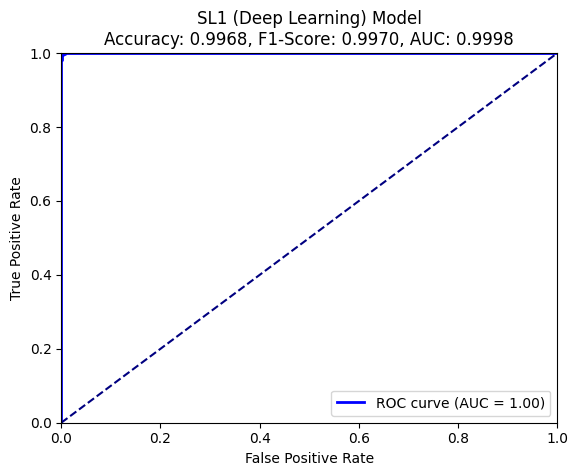

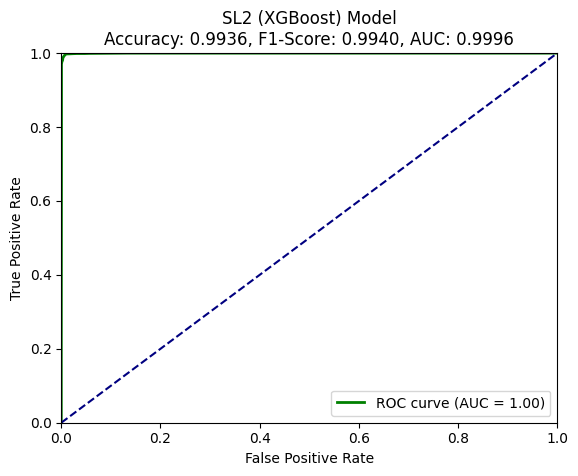


Final Results (Table 4):
                          Model       AUC  Accuracy  F1-Score
0           Logistic Regression  0.991393  0.955944  0.958644
1                           SVM  0.999465  0.990077  0.990647
2                       XGBoost  0.999881  0.998412  0.998505
3                 Deep Learning  0.999589  0.992459  0.992871
4       SL1: DL as meta-learner  0.999776  0.996825  0.997006
5  SL2: XGBoost as meta-learner  0.999565  0.993650  0.994014


In [ ]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# Define SVM model
svm_model = SVC(probability=True, random_state=42)

# Define XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit SVM and XGBoost models before using them in stacking or evaluation
svm_model.fit(X_train, y_train)  # Fit SVM model
xgb_model.fit(X_train, y_train)  # Fit XGBoost model

# Create SL1 Stacking model with DL as the meta-learner
sl1_estimators = [
    ('svm', SVC(probability=True, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# Add DL predictions as a new feature for stacking
X_train_sl1 = np.column_stack((X_train, dl_train_pred))
X_test_sl1 = np.column_stack((X_test, dl_test_pred))

sl1_model = StackingClassifier(estimators=sl1_estimators, final_estimator=LogisticRegression())
sl1_model.fit(X_train_sl1, y_train)

# Create SL2 Stacking model with GBM as the meta-learner
sl2_estimators = [
    ('svm', SVC(probability=True, random_state=42))
]

X_train_sl2 = np.column_stack((X_train, dl_train_pred))
X_test_sl2 = np.column_stack((X_test, dl_test_pred))

sl2_model = StackingClassifier(estimators=sl2_estimators, final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
sl2_model.fit(X_train_sl2, y_train)

# Define the models dictionary
models = {
    'Logistic Regression': lr_model,
    'SVM': svm_model,
    'XGBoost': xgb_model,
    'Deep Learning': dl_model,  # We'll handle this separately for DL
    'SL1: DL as meta-learner': sl1_model,
    'SL2: XGBoost as meta-learner': sl2_model
}

# Evaluate the models and store results
results = []

for name, model in models.items():
    if name == 'Deep Learning':
        y_pred = y_pred_dl
    else:
        y_pred = model.predict_proba(X_test_sl1 if 'SL1' in name else (X_test_sl2 if 'SL2' in name else X_test))[:, 1]

    accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
    f1 = f1_score(y_test, (y_pred > 0.5).astype(int))
    roc_auc = roc_auc_score(y_test, y_pred)

    results.append({
        'Model': name,
        'AUC': roc_auc,
        'Accuracy': accuracy,
        'F1-Score': f1
    })

    # ROC curve data
    if name == 'SL1: DL as meta-learner':
        fpr_sl1, tpr_sl1, _ = roc_curve(y_test, y_pred)
        roc_auc_sl1 = roc_auc
        accuracy_sl1 = accuracy
        f1_sl1 = f1
    elif name == 'SL2: XGBoost as meta-learner':
        fpr_sl2, tpr_sl2, _ = roc_curve(y_test, y_pred)
        roc_auc_sl2 = roc_auc
        accuracy_sl2 = accuracy
        f1_sl2 = f1

# Plot ROC curve for SL1
plt.figure()
plt.plot(fpr_sl1, tpr_sl1, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_sl1)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SL1 (Deep Learning) Model\nAccuracy: {:.4f}, F1-Score: {:.4f}, AUC: {:.4f}'.format(accuracy_sl1, f1_sl1, roc_auc_sl1))
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for SL2
plt.figure()
plt.plot(fpr_sl2, tpr_sl2, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_sl2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SL2 (XGBoost) Model\nAccuracy: {:.4f}, F1-Score: {:.4f}, AUC: {:.4f}'.format(accuracy_sl2, f1_sl2, roc_auc_sl2))
plt.legend(loc="lower right")
plt.show()

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print("\nFinal Results (Table 4):")
print(results_df)